# Обучение и оценка мульти-входовой нейронной сети

In [119]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 

# Импортируем нашу архитектуру модели из соседнего файла.
from multi_input_model import MultiInputModel

### Шаг 1: Конфигурация

ключевые гиперпараметры и настройки

In [120]:
# Список тестов в том порядке, в котором мы будем их загружать и подавать в модель.
TEST_NAMES = ["T1back", "TStroop", "T258", "T274", "T278"]
# Размер батча - количество примеров, обрабатываемых за один шаг обучения.
BATCH_SIZE = 32
# Скорость обучения (learning rate) - шаг, с которым модель обновляет свои веса.
LEARNING_RATE = 1e-4 
# Максимальное количество эпох обучения.
NUM_EPOCHS = 250
# "Терпение" для механизма ранней остановки. Если ошибка на валидации не улучшаетсяв течение `PATIENCE` эпох, обучение прекращается.
PATIENCE = 30 

# Важно: этот параметр должен совпадать с STROOP_PROCESSING_WAY в prepare_multi_test_data.py
STROOP_PROCESSING_WAY = 1

### Шаг 2: Загрузка данных
Здесь же происходит специальная обработка для теста Струпа, если был выбран способ подготовки `STROOP_PROCESSING_WAY = 1`.

In [121]:
print("Загрузка подготовленных данных...")
# Загружаем 5 массивов с данными тестов в список `Xs`.
Xs = []
for name in TEST_NAMES:
    data = np.load(f"X_{name}.npy")
    # Специальная обработка для TStroop, если он был сохранен как 4D тензор
    if name == "TStroop" and STROOP_PROCESSING_WAY == 1:
        # Преобразуем (batch_size, num_subtests, max_len_subtest, num_features) в
        # (batch_size, num_subtests * max_len_subtest, num_features)
        batch_size, num_subtests, max_len_subtest, num_features = data.shape
        data = data.reshape(batch_size, num_subtests * max_len_subtest, num_features)
        print(f"Данные TStroop преобразованы из 4D в 3D с формой: {data.shape}")
    Xs.append(data)
y = np.load("y_aligned.npy")

print("Данные успешно загружены.")

Загрузка подготовленных данных...
Данные TStroop преобразованы из 4D в 3D с формой: (5040, 116, 5)
Данные успешно загружены.


### Шаг 3: Разделение данных, Масштабирование и создание DataLoader'ов



In [122]:
# Константа для значения паддинга, чтобы не использовать магическое число
FILLING_VALUE = -1.0

# 1. Разделение индексов
indices = list(range(len(y)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

# 2. Обучение скейлеров и масштабирование данных
print("Масштабирование данных...")
scalers = [StandardScaler() for _ in TEST_NAMES]
Xs_scaled = [x.copy() for x in Xs] # Создаем копию данных для масштабирования

for i, (test_name, X_test) in enumerate(zip(TEST_NAMES, Xs)):
    # Выбираем данные для обучения скейлера
    train_data = X_test[train_indices]
    
    # Преобразуем 3D данные в 2D (n_samples * sequence_length, n_features)
    n_samples, seq_len, n_features = train_data.shape
    reshaped_train_data = train_data.reshape(-1, n_features)

    # Обучаем скейлер только на "активных" данных (не на паддинге)
    # Мы предполагаем, что если первый признак - это FILLING_VALUE, то вся строка является паддингом
    active_mask = reshaped_train_data[:, 0] != FILLING_VALUE
    scalers[i].fit(reshaped_train_data[active_mask])
    
    # Теперь применяем обученный скейлер ко всем данным (train, val, test)
    n_samples_total, seq_len_total, _ = X_test.shape
    reshaped_total_data = X_test.reshape(-1, n_features)
    
    total_active_mask = reshaped_total_data[:, 0] != FILLING_VALUE
    reshaped_total_data[total_active_mask] = scalers[i].transform(reshaped_total_data[total_active_mask])
    
    # Возвращаем данные в исходный 3D формат и сохраняем в Xs_scaled
    Xs_scaled[i] = reshaped_total_data.reshape(n_samples_total, seq_len_total, n_features)

print("Масштабирование завершено.")

# 3. Создание Dataset и DataLoader
class MultiInputDataset(Dataset):
    def __init__(self, xs_list, y_arr):
        self.xs = [torch.tensor(x, dtype=torch.float32) for x in xs_list]
        self.y = torch.tensor(y_arr, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [x[idx] for x in self.xs], self.y[idx]

def create_subset(indices_list):
    # Используем масштабированные данные Xs_scaled!
    subset_xs = [x[indices_list] for x in Xs_scaled]
    subset_y = y[indices_list]
    return MultiInputDataset(subset_xs, subset_y)

print("Создание загрузчиков данных (DataLoader)...")
train_dataset = create_subset(train_indices)
val_dataset = create_subset(val_indices)
test_dataset = create_subset(test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Загрузчики данных готовы.")

Масштабирование данных...
Масштабирование завершено.
Создание загрузчиков данных (DataLoader)...
Загрузчики данных готовы.


### Шаг 4: Инициализация модели, функции потерь и оптимизатора

In [123]:
# Собираем словарь с количеством признаков для каждого теста. Это нужно для инициализации модели.
input_dims = {name: Xs[i].shape[2] for i, name in enumerate(TEST_NAMES)}

model = MultiInputModel(input_dims=input_dims)
# Функция потерь (Loss Function). L1Loss - это MAE.
criterion = nn.L1Loss() 
# Оптимизатор. Adam - один из самых популярных и эффективных алгоритмов оптимизации.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Модель инициализирована:")
print(model)

Модель инициализирована:
MultiInputModel(
  (branches): ModuleDict(
    (T1back): SubtestBranch(
      (lstm): LSTM(13, 32, batch_first=True)
      (fc): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (TStroop): SubtestBranch(
      (lstm): LSTM(5, 32, batch_first=True)
      (fc): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (T258): SubtestBranch(
      (lstm): LSTM(10, 32, batch_first=True)
      (fc): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (T274): SubtestBranch(
      (lstm): LSTM(13, 32, batch_first=True)
      (fc): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (T278): SubtestBranch(
      (lstm): LSTM(13, 32, batch_first=True)
      (fc): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
  )
  (head): Sequential(
    (0): Linear(in_features=80, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropou

### Шаг 5: Цикл обучения

Запускаем основной цикл, в котором модель будет итеративно обучаться на данных, проходить валидацию и сохранять свою лучшую версию.

Начало обучения на 250 эпох...


Эпоха 1/250 [Обучение]:   0%|          | 0/95 [00:00<?, ?it/s]

Эпоха 1/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 50.50it/s]


Эпоха [1/250] | Ошибка на обучении: 44.2612 | Ошибка на валидации (MAE): 44.6845
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 2/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.80it/s]


Эпоха [2/250] | Ошибка на обучении: 42.8447 | Ошибка на валидации (MAE): 40.4249
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 3/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 48.80it/s]


Эпоха [3/250] | Ошибка на обучении: 25.3966 | Ошибка на валидации (MAE): 12.3038
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 4/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.83it/s]


Эпоха [4/250] | Ошибка на обучении: 12.5130 | Ошибка на валидации (MAE): 12.2229
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 5/250 [Обучение]: 100%|██████████| 95/95 [00:02<00:00, 47.29it/s]


Эпоха [5/250] | Ошибка на обучении: 12.6580 | Ошибка на валидации (MAE): 12.2052
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 6/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 49.58it/s]


Эпоха [6/250] | Ошибка на обучении: 12.5269 | Ошибка на валидации (MAE): 12.0331
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 7/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.46it/s]


Эпоха [7/250] | Ошибка на обучении: 12.3911 | Ошибка на валидации (MAE): 12.0440


Эпоха 8/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.36it/s]


Эпоха [8/250] | Ошибка на обучении: 12.2711 | Ошибка на валидации (MAE): 11.8267
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 9/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.81it/s]


Эпоха [9/250] | Ошибка на обучении: 12.1254 | Ошибка на валидации (MAE): 11.6294
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 10/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.73it/s]


Эпоха [10/250] | Ошибка на обучении: 11.9550 | Ошибка на валидации (MAE): 11.2490
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 11/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.11it/s]


Эпоха [11/250] | Ошибка на обучении: 11.4537 | Ошибка на валидации (MAE): 10.9339
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 12/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.06it/s]


Эпоха [12/250] | Ошибка на обучении: 11.1948 | Ошибка на валидации (MAE): 10.8883
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 13/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.16it/s]


Эпоха [13/250] | Ошибка на обучении: 11.2312 | Ошибка на валидации (MAE): 10.8160
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 14/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.85it/s]


Эпоха [14/250] | Ошибка на обучении: 11.0273 | Ошибка на валидации (MAE): 10.5601
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 15/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.11it/s]


Эпоха [15/250] | Ошибка на обучении: 10.8388 | Ошибка на валидации (MAE): 10.3201
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 16/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.43it/s]


Эпоха [16/250] | Ошибка на обучении: 10.7719 | Ошибка на валидации (MAE): 10.0291
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 17/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.41it/s]


Эпоха [17/250] | Ошибка на обучении: 10.3103 | Ошибка на валидации (MAE): 9.9184
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 18/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.65it/s]


Эпоха [18/250] | Ошибка на обучении: 10.2204 | Ошибка на валидации (MAE): 9.9154
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 19/250 [Обучение]: 100%|██████████| 95/95 [00:02<00:00, 45.16it/s]


Эпоха [19/250] | Ошибка на обучении: 10.1299 | Ошибка на валидации (MAE): 9.6650
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 20/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 50.00it/s]


Эпоха [20/250] | Ошибка на обучении: 10.1255 | Ошибка на валидации (MAE): 9.9227


Эпоха 21/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 47.85it/s]


Эпоха [21/250] | Ошибка на обучении: 10.0384 | Ошибка на валидации (MAE): 9.5207
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 22/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.05it/s]


Эпоха [22/250] | Ошибка на обучении: 9.8233 | Ошибка на валидации (MAE): 9.6706


Эпоха 23/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 51.48it/s]


Эпоха [23/250] | Ошибка на обучении: 9.8800 | Ошибка на валидации (MAE): 9.2578
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 24/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.60it/s]


Эпоха [24/250] | Ошибка на обучении: 9.8537 | Ошибка на валидации (MAE): 9.1215
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 25/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.85it/s]


Эпоха [25/250] | Ошибка на обучении: 9.7270 | Ошибка на валидации (MAE): 9.0298
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 26/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.48it/s]


Эпоха [26/250] | Ошибка на обучении: 9.4099 | Ошибка на валидации (MAE): 9.3475


Эпоха 27/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.11it/s]


Эпоха [27/250] | Ошибка на обучении: 9.6224 | Ошибка на валидации (MAE): 9.0352


Эпоха 28/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.67it/s]


Эпоха [28/250] | Ошибка на обучении: 9.6025 | Ошибка на валидации (MAE): 9.2127


Эпоха 29/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.33it/s]


Эпоха [29/250] | Ошибка на обучении: 9.5981 | Ошибка на валидации (MAE): 8.9945
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 30/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.25it/s]


Эпоха [30/250] | Ошибка на обучении: 9.4910 | Ошибка на валидации (MAE): 8.9481
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 31/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 50.53it/s]


Эпоха [31/250] | Ошибка на обучении: 9.5327 | Ошибка на валидации (MAE): 9.0743


Эпоха 32/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.21it/s]


Эпоха [32/250] | Ошибка на обучении: 9.4915 | Ошибка на валидации (MAE): 9.0081


Эпоха 33/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.90it/s]


Эпоха [33/250] | Ошибка на обучении: 9.6759 | Ошибка на валидации (MAE): 9.0233


Эпоха 34/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.23it/s]


Эпоха [34/250] | Ошибка на обучении: 9.4441 | Ошибка на валидации (MAE): 8.9503


Эпоха 35/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.44it/s]


Эпоха [35/250] | Ошибка на обучении: 9.5286 | Ошибка на валидации (MAE): 9.1316


Эпоха 36/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 51.17it/s]


Эпоха [36/250] | Ошибка на обучении: 9.4770 | Ошибка на валидации (MAE): 8.7879
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 37/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.92it/s]


Эпоха [37/250] | Ошибка на обучении: 9.5594 | Ошибка на валидации (MAE): 8.9772


Эпоха 38/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.31it/s]


Эпоха [38/250] | Ошибка на обучении: 9.5432 | Ошибка на валидации (MAE): 8.8686


Эпоха 39/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.24it/s]


Эпоха [39/250] | Ошибка на обучении: 9.3581 | Ошибка на валидации (MAE): 9.1887


Эпоха 40/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.71it/s]


Эпоха [40/250] | Ошибка на обучении: 9.4596 | Ошибка на валидации (MAE): 9.0867


Эпоха 41/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.85it/s]


Эпоха [41/250] | Ошибка на обучении: 9.1914 | Ошибка на валидации (MAE): 8.9382


Эпоха 42/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.91it/s]


Эпоха [42/250] | Ошибка на обучении: 9.3749 | Ошибка на валидации (MAE): 8.7989


Эпоха 43/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.40it/s]


Эпоха [43/250] | Ошибка на обучении: 9.3187 | Ошибка на валидации (MAE): 8.9579


Эпоха 44/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.78it/s]


Эпоха [44/250] | Ошибка на обучении: 9.4020 | Ошибка на валидации (MAE): 8.8672


Эпоха 45/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.79it/s]


Эпоха [45/250] | Ошибка на обучении: 9.3111 | Ошибка на валидации (MAE): 8.7283
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 46/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.80it/s]


Эпоха [46/250] | Ошибка на обучении: 9.3950 | Ошибка на валидации (MAE): 8.7417


Эпоха 47/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.44it/s]


Эпоха [47/250] | Ошибка на обучении: 9.3717 | Ошибка на валидации (MAE): 8.6786
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 48/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.02it/s]


Эпоха [48/250] | Ошибка на обучении: 9.3008 | Ошибка на валидации (MAE): 8.7383


Эпоха 49/250 [Обучение]: 100%|██████████| 95/95 [00:02<00:00, 45.90it/s]


Эпоха [49/250] | Ошибка на обучении: 9.3216 | Ошибка на валидации (MAE): 8.7869


Эпоха 50/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.41it/s]


Эпоха [50/250] | Ошибка на обучении: 9.3108 | Ошибка на валидации (MAE): 8.7257


Эпоха 51/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.43it/s]


Эпоха [51/250] | Ошибка на обучении: 9.1980 | Ошибка на валидации (MAE): 8.7111


Эпоха 52/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 51.93it/s]


Эпоха [52/250] | Ошибка на обучении: 9.2527 | Ошибка на валидации (MAE): 8.6599
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 53/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.82it/s]


Эпоха [53/250] | Ошибка на обучении: 9.2200 | Ошибка на валидации (MAE): 8.9871


Эпоха 54/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.16it/s]


Эпоха [54/250] | Ошибка на обучении: 9.3469 | Ошибка на валидации (MAE): 8.6988


Эпоха 55/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.17it/s]


Эпоха [55/250] | Ошибка на обучении: 9.1521 | Ошибка на валидации (MAE): 8.7373


Эпоха 56/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.70it/s]


Эпоха [56/250] | Ошибка на обучении: 9.2263 | Ошибка на валидации (MAE): 8.7371


Эпоха 57/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.17it/s]


Эпоха [57/250] | Ошибка на обучении: 9.2698 | Ошибка на валидации (MAE): 8.9332


Эпоха 58/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.97it/s]


Эпоха [58/250] | Ошибка на обучении: 9.1688 | Ошибка на валидации (MAE): 8.6815


Эпоха 59/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.48it/s]


Эпоха [59/250] | Ошибка на обучении: 9.0866 | Ошибка на валидации (MAE): 8.8370


Эпоха 60/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.00it/s]


Эпоха [60/250] | Ошибка на обучении: 9.2632 | Ошибка на валидации (MAE): 8.6144
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 61/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.25it/s]


Эпоха [61/250] | Ошибка на обучении: 9.2028 | Ошибка на валидации (MAE): 8.6448


Эпоха 62/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.85it/s]


Эпоха [62/250] | Ошибка на обучении: 9.1423 | Ошибка на валидации (MAE): 8.7319


Эпоха 63/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.87it/s]


Эпоха [63/250] | Ошибка на обучении: 9.1469 | Ошибка на валидации (MAE): 8.5779
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 64/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.65it/s]


Эпоха [64/250] | Ошибка на обучении: 9.1818 | Ошибка на валидации (MAE): 8.5635
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 65/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.33it/s]


Эпоха [65/250] | Ошибка на обучении: 9.2196 | Ошибка на валидации (MAE): 8.8240


Эпоха 66/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.81it/s]


Эпоха [66/250] | Ошибка на обучении: 9.0435 | Ошибка на валидации (MAE): 8.6148


Эпоха 67/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.32it/s]


Эпоха [67/250] | Ошибка на обучении: 9.2363 | Ошибка на валидации (MAE): 8.6479


Эпоха 68/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.40it/s]


Эпоха [68/250] | Ошибка на обучении: 9.0877 | Ошибка на валидации (MAE): 8.8904


Эпоха 69/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.75it/s]


Эпоха [69/250] | Ошибка на обучении: 8.9972 | Ошибка на валидации (MAE): 8.6161


Эпоха 70/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.06it/s]


Эпоха [70/250] | Ошибка на обучении: 9.0912 | Ошибка на валидации (MAE): 8.6068


Эпоха 71/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.35it/s]


Эпоха [71/250] | Ошибка на обучении: 9.1132 | Ошибка на валидации (MAE): 8.7742


Эпоха 72/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.26it/s]


Эпоха [72/250] | Ошибка на обучении: 9.2780 | Ошибка на валидации (MAE): 8.6296


Эпоха 73/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.57it/s]


Эпоха [73/250] | Ошибка на обучении: 9.0445 | Ошибка на валидации (MAE): 8.5667


Эпоха 74/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.31it/s]


Эпоха [74/250] | Ошибка на обучении: 9.0911 | Ошибка на валидации (MAE): 8.6229


Эпоха 75/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.92it/s]


Эпоха [75/250] | Ошибка на обучении: 9.0213 | Ошибка на валидации (MAE): 8.5314
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 76/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.55it/s]


Эпоха [76/250] | Ошибка на обучении: 9.0397 | Ошибка на валидации (MAE): 9.0306


Эпоха 77/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.95it/s]


Эпоха [77/250] | Ошибка на обучении: 9.0646 | Ошибка на валидации (MAE): 8.5160
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 78/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.21it/s]


Эпоха [78/250] | Ошибка на обучении: 9.0867 | Ошибка на валидации (MAE): 8.8002


Эпоха 79/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.11it/s]


Эпоха [79/250] | Ошибка на обучении: 9.0207 | Ошибка на валидации (MAE): 8.5384


Эпоха 80/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.97it/s]


Эпоха [80/250] | Ошибка на обучении: 9.0748 | Ошибка на валидации (MAE): 8.6217


Эпоха 81/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.57it/s]


Эпоха [81/250] | Ошибка на обучении: 9.1935 | Ошибка на валидации (MAE): 8.6248


Эпоха 82/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.32it/s]


Эпоха [82/250] | Ошибка на обучении: 9.0020 | Ошибка на валидации (MAE): 8.5273


Эпоха 83/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.01it/s]


Эпоха [83/250] | Ошибка на обучении: 8.9682 | Ошибка на валидации (MAE): 8.5095
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 84/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.31it/s]


Эпоха [84/250] | Ошибка на обучении: 8.8763 | Ошибка на валидации (MAE): 8.5710


Эпоха 85/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.94it/s]


Эпоха [85/250] | Ошибка на обучении: 8.9511 | Ошибка на валидации (MAE): 8.6085


Эпоха 86/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.89it/s]


Эпоха [86/250] | Ошибка на обучении: 9.0396 | Ошибка на валидации (MAE): 8.4535
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 87/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.30it/s]


Эпоха [87/250] | Ошибка на обучении: 8.9807 | Ошибка на валидации (MAE): 8.5714


Эпоха 88/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.94it/s]


Эпоха [88/250] | Ошибка на обучении: 8.8693 | Ошибка на валидации (MAE): 8.5574


Эпоха 89/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 50.43it/s]


Эпоха [89/250] | Ошибка на обучении: 9.0226 | Ошибка на валидации (MAE): 8.4739


Эпоха 90/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.55it/s]


Эпоха [90/250] | Ошибка на обучении: 9.0186 | Ошибка на валидации (MAE): 8.5587


Эпоха 91/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.61it/s]


Эпоха [91/250] | Ошибка на обучении: 9.0297 | Ошибка на валидации (MAE): 8.6443


Эпоха 92/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.91it/s]


Эпоха [92/250] | Ошибка на обучении: 8.8769 | Ошибка на валидации (MAE): 8.4762


Эпоха 93/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.22it/s]


Эпоха [93/250] | Ошибка на обучении: 8.9031 | Ошибка на валидации (MAE): 8.4600


Эпоха 94/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.84it/s]


Эпоха [94/250] | Ошибка на обучении: 8.9338 | Ошибка на валидации (MAE): 8.4864


Эпоха 95/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.49it/s]


Эпоха [95/250] | Ошибка на обучении: 8.9296 | Ошибка на валидации (MAE): 8.6039


Эпоха 96/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.94it/s]


Эпоха [96/250] | Ошибка на обучении: 8.7767 | Ошибка на валидации (MAE): 8.4945


Эпоха 97/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.83it/s]


Эпоха [97/250] | Ошибка на обучении: 8.8528 | Ошибка на валидации (MAE): 8.4917


Эпоха 98/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.81it/s]


Эпоха [98/250] | Ошибка на обучении: 9.0658 | Ошибка на валидации (MAE): 8.4440
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 99/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.80it/s]


Эпоха [99/250] | Ошибка на обучении: 8.9129 | Ошибка на валидации (MAE): 8.4899


Эпоха 100/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.49it/s]


Эпоха [100/250] | Ошибка на обучении: 9.0062 | Ошибка на валидации (MAE): 8.4800


Эпоха 101/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.28it/s]


Эпоха [101/250] | Ошибка на обучении: 8.7702 | Ошибка на валидации (MAE): 8.5155


Эпоха 102/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.13it/s]


Эпоха [102/250] | Ошибка на обучении: 8.8089 | Ошибка на валидации (MAE): 8.4906


Эпоха 103/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.06it/s]


Эпоха [103/250] | Ошибка на обучении: 8.9206 | Ошибка на валидации (MAE): 8.4728


Эпоха 104/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.99it/s]


Эпоха [104/250] | Ошибка на обучении: 8.7399 | Ошибка на валидации (MAE): 8.4885


Эпоха 105/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.00it/s]


Эпоха [105/250] | Ошибка на обучении: 8.7565 | Ошибка на валидации (MAE): 8.5679


Эпоха 106/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.29it/s]


Эпоха [106/250] | Ошибка на обучении: 8.9606 | Ошибка на валидации (MAE): 8.7438


Эпоха 107/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.18it/s]


Эпоха [107/250] | Ошибка на обучении: 8.8478 | Ошибка на валидации (MAE): 8.7403


Эпоха 108/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.26it/s]


Эпоха [108/250] | Ошибка на обучении: 8.8911 | Ошибка на валидации (MAE): 8.4541


Эпоха 109/250 [Обучение]: 100%|██████████| 95/95 [00:02<00:00, 45.99it/s]


Эпоха [109/250] | Ошибка на обучении: 8.7924 | Ошибка на валидации (MAE): 8.4313
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 110/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 50.54it/s]


Эпоха [110/250] | Ошибка на обучении: 8.8053 | Ошибка на валидации (MAE): 8.4384


Эпоха 111/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 48.84it/s]


Эпоха [111/250] | Ошибка на обучении: 8.8234 | Ошибка на валидации (MAE): 8.6269


Эпоха 112/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 50.29it/s]


Эпоха [112/250] | Ошибка на обучении: 8.9393 | Ошибка на валидации (MAE): 8.4705


Эпоха 113/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 50.20it/s]


Эпоха [113/250] | Ошибка на обучении: 8.7957 | Ошибка на валидации (MAE): 8.5194


Эпоха 114/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.04it/s]


Эпоха [114/250] | Ошибка на обучении: 8.8219 | Ошибка на валидации (MAE): 8.4306
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 115/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.77it/s]


Эпоха [115/250] | Ошибка на обучении: 8.9560 | Ошибка на валидации (MAE): 8.6716


Эпоха 116/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.89it/s]


Эпоха [116/250] | Ошибка на обучении: 8.8246 | Ошибка на валидации (MAE): 8.5202


Эпоха 117/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.97it/s]


Эпоха [117/250] | Ошибка на обучении: 8.8043 | Ошибка на валидации (MAE): 8.4641


Эпоха 118/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.90it/s]


Эпоха [118/250] | Ошибка на обучении: 8.8290 | Ошибка на валидации (MAE): 8.5314


Эпоха 119/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.71it/s]


Эпоха [119/250] | Ошибка на обучении: 8.6868 | Ошибка на валидации (MAE): 8.5323


Эпоха 120/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 48.59it/s]


Эпоха [120/250] | Ошибка на обучении: 8.7621 | Ошибка на валидации (MAE): 8.8849


Эпоха 121/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 52.93it/s]


Эпоха [121/250] | Ошибка на обучении: 8.8058 | Ошибка на валидации (MAE): 8.5379


Эпоха 122/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.54it/s]


Эпоха [122/250] | Ошибка на обучении: 8.7949 | Ошибка на валидации (MAE): 8.5393


Эпоха 123/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.77it/s]


Эпоха [123/250] | Ошибка на обучении: 8.6200 | Ошибка на валидации (MAE): 8.4715


Эпоха 124/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.93it/s]


Эпоха [124/250] | Ошибка на обучении: 8.7516 | Ошибка на валидации (MAE): 8.5060


Эпоха 125/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.36it/s]


Эпоха [125/250] | Ошибка на обучении: 8.6985 | Ошибка на валидации (MAE): 8.5237


Эпоха 126/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.43it/s]


Эпоха [126/250] | Ошибка на обучении: 8.8766 | Ошибка на валидации (MAE): 8.7491


Эпоха 127/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.41it/s]


Эпоха [127/250] | Ошибка на обучении: 8.6379 | Ошибка на валидации (MAE): 8.4229
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 128/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.08it/s]


Эпоха [128/250] | Ошибка на обучении: 8.6862 | Ошибка на валидации (MAE): 8.4452


Эпоха 129/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.74it/s]


Эпоха [129/250] | Ошибка на обучении: 8.6800 | Ошибка на валидации (MAE): 8.5405


Эпоха 130/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.52it/s]


Эпоха [130/250] | Ошибка на обучении: 8.7129 | Ошибка на валидации (MAE): 8.4686


Эпоха 131/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.46it/s]


Эпоха [131/250] | Ошибка на обучении: 8.8228 | Ошибка на валидации (MAE): 8.7382


Эпоха 132/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.18it/s]


Эпоха [132/250] | Ошибка на обучении: 8.8339 | Ошибка на валидации (MAE): 8.5395


Эпоха 133/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.22it/s]


Эпоха [133/250] | Ошибка на обучении: 8.6472 | Ошибка на валидации (MAE): 8.4985


Эпоха 134/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.58it/s]


Эпоха [134/250] | Ошибка на обучении: 8.8153 | Ошибка на валидации (MAE): 8.5399


Эпоха 135/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.99it/s]


Эпоха [135/250] | Ошибка на обучении: 8.6710 | Ошибка на валидации (MAE): 8.4515


Эпоха 136/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.95it/s]


Эпоха [136/250] | Ошибка на обучении: 8.7111 | Ошибка на валидации (MAE): 8.5041


Эпоха 137/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.03it/s]


Эпоха [137/250] | Ошибка на обучении: 8.6225 | Ошибка на валидации (MAE): 8.5003


Эпоха 138/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.86it/s]


Эпоха [138/250] | Ошибка на обучении: 8.7258 | Ошибка на валидации (MAE): 8.5818


Эпоха 139/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.18it/s]


Эпоха [139/250] | Ошибка на обучении: 8.8095 | Ошибка на валидации (MAE): 8.5814


Эпоха 140/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.34it/s]


Эпоха [140/250] | Ошибка на обучении: 8.5994 | Ошибка на валидации (MAE): 8.6220


Эпоха 141/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.80it/s]


Эпоха [141/250] | Ошибка на обучении: 8.6083 | Ошибка на валидации (MAE): 8.4675


Эпоха 142/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.17it/s]


Эпоха [142/250] | Ошибка на обучении: 8.5286 | Ошибка на валидации (MAE): 8.6098


Эпоха 143/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.90it/s]


Эпоха [143/250] | Ошибка на обучении: 8.7181 | Ошибка на валидации (MAE): 8.5619


Эпоха 144/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.85it/s]


Эпоха [144/250] | Ошибка на обучении: 8.7828 | Ошибка на валидации (MAE): 8.4366


Эпоха 145/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.42it/s]


Эпоха [145/250] | Ошибка на обучении: 8.6780 | Ошибка на валидации (MAE): 8.4849


Эпоха 146/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.68it/s]


Эпоха [146/250] | Ошибка на обучении: 8.6526 | Ошибка на валидации (MAE): 8.6177


Эпоха 147/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.06it/s]


Эпоха [147/250] | Ошибка на обучении: 8.6617 | Ошибка на валидации (MAE): 8.4115
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 148/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.84it/s]


Эпоха [148/250] | Ошибка на обучении: 8.5831 | Ошибка на валидации (MAE): 8.4417


Эпоха 149/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.62it/s]


Эпоха [149/250] | Ошибка на обучении: 8.5897 | Ошибка на валидации (MAE): 8.5450


Эпоха 150/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.12it/s]


Эпоха [150/250] | Ошибка на обучении: 8.7034 | Ошибка на валидации (MAE): 8.6838


Эпоха 151/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.49it/s]


Эпоха [151/250] | Ошибка на обучении: 8.6021 | Ошибка на валидации (MAE): 8.4994


Эпоха 152/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.92it/s]


Эпоха [152/250] | Ошибка на обучении: 8.5360 | Ошибка на валидации (MAE): 8.4255


Эпоха 153/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.64it/s]


Эпоха [153/250] | Ошибка на обучении: 8.6164 | Ошибка на валидации (MAE): 8.4346


Эпоха 154/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.09it/s]


Эпоха [154/250] | Ошибка на обучении: 8.5250 | Ошибка на валидации (MAE): 8.7291


Эпоха 155/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 53.89it/s]


Эпоха [155/250] | Ошибка на обучении: 8.7451 | Ошибка на валидации (MAE): 8.5675


Эпоха 156/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.08it/s]


Эпоха [156/250] | Ошибка на обучении: 8.6474 | Ошибка на валидации (MAE): 8.6257


Эпоха 157/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.11it/s]


Эпоха [157/250] | Ошибка на обучении: 8.4639 | Ошибка на валидации (MAE): 8.4510


Эпоха 158/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.37it/s]


Эпоха [158/250] | Ошибка на обучении: 8.4964 | Ошибка на валидации (MAE): 8.6388


Эпоха 159/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.00it/s]


Эпоха [159/250] | Ошибка на обучении: 8.6022 | Ошибка на валидации (MAE): 8.4563


Эпоха 160/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 64.21it/s]


Эпоха [160/250] | Ошибка на обучении: 8.6280 | Ошибка на валидации (MAE): 8.6793


Эпоха 161/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.27it/s]


Эпоха [161/250] | Ошибка на обучении: 8.4914 | Ошибка на валидации (MAE): 8.4307


Эпоха 162/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.78it/s]


Эпоха [162/250] | Ошибка на обучении: 8.6917 | Ошибка на валидации (MAE): 8.4024
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 163/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.97it/s]


Эпоха [163/250] | Ошибка на обучении: 8.4132 | Ошибка на валидации (MAE): 8.4425


Эпоха 164/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.52it/s]


Эпоха [164/250] | Ошибка на обучении: 8.5109 | Ошибка на валидации (MAE): 8.4858


Эпоха 165/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.05it/s]


Эпоха [165/250] | Ошибка на обучении: 8.5173 | Ошибка на валидации (MAE): 8.4532


Эпоха 166/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.36it/s]


Эпоха [166/250] | Ошибка на обучении: 8.6210 | Ошибка на валидации (MAE): 8.5808


Эпоха 167/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.74it/s]


Эпоха [167/250] | Ошибка на обучении: 8.5550 | Ошибка на валидации (MAE): 8.4470


Эпоха 168/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.20it/s]


Эпоха [168/250] | Ошибка на обучении: 8.4620 | Ошибка на валидации (MAE): 8.4258


Эпоха 169/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.97it/s]


Эпоха [169/250] | Ошибка на обучении: 8.3854 | Ошибка на валидации (MAE): 8.6000


Эпоха 170/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.22it/s]


Эпоха [170/250] | Ошибка на обучении: 8.5154 | Ошибка на валидации (MAE): 8.5157


Эпоха 171/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.45it/s]


Эпоха [171/250] | Ошибка на обучении: 8.5151 | Ошибка на валидации (MAE): 8.6741


Эпоха 172/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.42it/s]


Эпоха [172/250] | Ошибка на обучении: 8.6281 | Ошибка на валидации (MAE): 8.5148


Эпоха 173/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.77it/s]


Эпоха [173/250] | Ошибка на обучении: 8.6919 | Ошибка на валидации (MAE): 8.4817


Эпоха 174/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.99it/s]


Эпоха [174/250] | Ошибка на обучении: 8.7260 | Ошибка на валидации (MAE): 8.4553


Эпоха 175/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.30it/s]


Эпоха [175/250] | Ошибка на обучении: 8.5129 | Ошибка на валидации (MAE): 8.5068


Эпоха 176/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.03it/s]


Эпоха [176/250] | Ошибка на обучении: 8.5657 | Ошибка на валидации (MAE): 8.4843


Эпоха 177/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.94it/s]


Эпоха [177/250] | Ошибка на обучении: 8.5693 | Ошибка на валидации (MAE): 8.8679


Эпоха 178/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.29it/s]


Эпоха [178/250] | Ошибка на обучении: 8.4258 | Ошибка на валидации (MAE): 8.8286


Эпоха 179/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.25it/s]


Эпоха [179/250] | Ошибка на обучении: 8.4154 | Ошибка на валидации (MAE): 8.5755


Эпоха 180/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.80it/s]


Эпоха [180/250] | Ошибка на обучении: 8.4994 | Ошибка на валидации (MAE): 8.5239


Эпоха 181/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 63.41it/s]


Эпоха [181/250] | Ошибка на обучении: 8.5417 | Ошибка на валидации (MAE): 8.4139


Эпоха 182/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 49.30it/s]


Эпоха [182/250] | Ошибка на обучении: 8.3823 | Ошибка на валидации (MAE): 8.4852


Эпоха 183/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.29it/s]


Эпоха [183/250] | Ошибка на обучении: 8.4794 | Ошибка на валидации (MAE): 8.3939
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 184/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.32it/s]


Эпоха [184/250] | Ошибка на обучении: 8.4864 | Ошибка на валидации (MAE): 8.4347


Эпоха 185/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.88it/s]


Эпоха [185/250] | Ошибка на обучении: 8.5222 | Ошибка на валидации (MAE): 8.4818


Эпоха 186/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.11it/s]


Эпоха [186/250] | Ошибка на обучении: 8.4484 | Ошибка на валидации (MAE): 8.5773


Эпоха 187/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.20it/s]


Эпоха [187/250] | Ошибка на обучении: 8.4996 | Ошибка на валидации (MAE): 8.7494


Эпоха 188/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.35it/s]


Эпоха [188/250] | Ошибка на обучении: 8.6045 | Ошибка на валидации (MAE): 8.4602


Эпоха 189/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.98it/s]


Эпоха [189/250] | Ошибка на обучении: 8.5468 | Ошибка на валидации (MAE): 8.4135


Эпоха 190/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.88it/s]


Эпоха [190/250] | Ошибка на обучении: 8.5263 | Ошибка на валидации (MAE): 8.3932
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 191/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 64.01it/s]


Эпоха [191/250] | Ошибка на обучении: 8.4209 | Ошибка на валидации (MAE): 8.4346


Эпоха 192/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.23it/s]


Эпоха [192/250] | Ошибка на обучении: 8.4586 | Ошибка на валидации (MAE): 8.7268


Эпоха 193/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.23it/s]


Эпоха [193/250] | Ошибка на обучении: 8.5272 | Ошибка на валидации (MAE): 8.3690
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 194/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.07it/s]


Эпоха [194/250] | Ошибка на обучении: 8.4285 | Ошибка на валидации (MAE): 8.5347


Эпоха 195/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.80it/s]


Эпоха [195/250] | Ошибка на обучении: 8.4472 | Ошибка на валидации (MAE): 8.4426


Эпоха 196/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.29it/s]


Эпоха [196/250] | Ошибка на обучении: 8.2788 | Ошибка на валидации (MAE): 8.4182


Эпоха 197/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.52it/s]


Эпоха [197/250] | Ошибка на обучении: 8.4009 | Ошибка на валидации (MAE): 8.4923


Эпоха 198/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.92it/s]


Эпоха [198/250] | Ошибка на обучении: 8.4354 | Ошибка на валидации (MAE): 8.4180


Эпоха 199/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.07it/s]


Эпоха [199/250] | Ошибка на обучении: 8.3602 | Ошибка на валидации (MAE): 8.9608


Эпоха 200/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.39it/s]


Эпоха [200/250] | Ошибка на обучении: 8.2881 | Ошибка на валидации (MAE): 8.3859


Эпоха 201/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.86it/s]


Эпоха [201/250] | Ошибка на обучении: 8.5236 | Ошибка на валидации (MAE): 8.5170


Эпоха 202/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.36it/s]


Эпоха [202/250] | Ошибка на обучении: 8.3356 | Ошибка на валидации (MAE): 8.3668
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 203/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.85it/s]


Эпоха [203/250] | Ошибка на обучении: 8.3671 | Ошибка на валидации (MAE): 8.4118


Эпоха 204/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.40it/s]


Эпоха [204/250] | Ошибка на обучении: 8.3018 | Ошибка на валидации (MAE): 8.5837


Эпоха 205/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.24it/s]


Эпоха [205/250] | Ошибка на обучении: 8.4380 | Ошибка на валидации (MAE): 8.3837


Эпоха 206/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.68it/s]


Эпоха [206/250] | Ошибка на обучении: 8.4000 | Ошибка на валидации (MAE): 8.4243


Эпоха 207/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.15it/s]


Эпоха [207/250] | Ошибка на обучении: 8.3208 | Ошибка на валидации (MAE): 8.4966


Эпоха 208/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.26it/s]


Эпоха [208/250] | Ошибка на обучении: 8.3399 | Ошибка на валидации (MAE): 8.4815


Эпоха 209/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.74it/s]


Эпоха [209/250] | Ошибка на обучении: 8.4441 | Ошибка на валидации (MAE): 8.7592


Эпоха 210/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 63.44it/s]


Эпоха [210/250] | Ошибка на обучении: 8.4038 | Ошибка на валидации (MAE): 8.5926


Эпоха 211/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.89it/s]


Эпоха [211/250] | Ошибка на обучении: 8.3384 | Ошибка на валидации (MAE): 8.3672


Эпоха 212/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.50it/s]


Эпоха [212/250] | Ошибка на обучении: 8.2619 | Ошибка на валидации (MAE): 8.3912


Эпоха 213/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.31it/s]


Эпоха [213/250] | Ошибка на обучении: 8.1724 | Ошибка на валидации (MAE): 8.4604


Эпоха 214/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 62.19it/s]


Эпоха [214/250] | Ошибка на обучении: 8.3957 | Ошибка на валидации (MAE): 8.4281


Эпоха 215/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.57it/s]


Эпоха [215/250] | Ошибка на обучении: 8.4455 | Ошибка на валидации (MAE): 8.4170


Эпоха 216/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.81it/s]


Эпоха [216/250] | Ошибка на обучении: 8.2413 | Ошибка на валидации (MAE): 8.3809


Эпоха 217/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 58.55it/s]


Эпоха [217/250] | Ошибка на обучении: 8.5348 | Ошибка на валидации (MAE): 8.3437
Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'


Эпоха 218/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.75it/s]


Эпоха [218/250] | Ошибка на обучении: 8.2551 | Ошибка на валидации (MAE): 8.3834


Эпоха 219/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.41it/s]


Эпоха [219/250] | Ошибка на обучении: 8.2494 | Ошибка на валидации (MAE): 8.4195


Эпоха 220/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.57it/s]


Эпоха [220/250] | Ошибка на обучении: 8.3242 | Ошибка на валидации (MAE): 8.6952


Эпоха 221/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.63it/s]


Эпоха [221/250] | Ошибка на обучении: 8.3551 | Ошибка на валидации (MAE): 8.3643


Эпоха 222/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.69it/s]


Эпоха [222/250] | Ошибка на обучении: 8.1972 | Ошибка на валидации (MAE): 8.4592


Эпоха 223/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.93it/s]


Эпоха [223/250] | Ошибка на обучении: 8.2793 | Ошибка на валидации (MAE): 8.5713


Эпоха 224/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.78it/s]


Эпоха [224/250] | Ошибка на обучении: 8.2661 | Ошибка на валидации (MAE): 8.5791


Эпоха 225/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.73it/s]


Эпоха [225/250] | Ошибка на обучении: 8.3861 | Ошибка на валидации (MAE): 8.5070


Эпоха 226/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.20it/s]


Эпоха [226/250] | Ошибка на обучении: 8.0605 | Ошибка на валидации (MAE): 8.3737


Эпоха 227/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 65.84it/s]


Эпоха [227/250] | Ошибка на обучении: 8.3414 | Ошибка на валидации (MAE): 8.3490


Эпоха 228/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.52it/s]


Эпоха [228/250] | Ошибка на обучении: 8.2711 | Ошибка на валидации (MAE): 8.5170


Эпоха 229/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 64.28it/s]


Эпоха [229/250] | Ошибка на обучении: 8.4003 | Ошибка на валидации (MAE): 8.3448


Эпоха 230/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 60.86it/s]


Эпоха [230/250] | Ошибка на обучении: 8.2387 | Ошибка на валидации (MAE): 8.3844


Эпоха 231/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 61.93it/s]


Эпоха [231/250] | Ошибка на обучении: 8.1533 | Ошибка на валидации (MAE): 8.3902


Эпоха 232/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.95it/s]


Эпоха [232/250] | Ошибка на обучении: 8.1430 | Ошибка на валидации (MAE): 8.3704


Эпоха 233/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 51.63it/s]


Эпоха [233/250] | Ошибка на обучении: 8.1828 | Ошибка на валидации (MAE): 8.3948


Эпоха 234/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 59.70it/s]


Эпоха [234/250] | Ошибка на обучении: 8.2284 | Ошибка на валидации (MAE): 8.4048


Эпоха 235/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.02it/s]


Эпоха [235/250] | Ошибка на обучении: 8.2040 | Ошибка на валидации (MAE): 8.4823


Эпоха 236/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.41it/s]


Эпоха [236/250] | Ошибка на обучении: 8.1836 | Ошибка на валидации (MAE): 8.3850


Эпоха 237/250 [Обучение]: 100%|██████████| 95/95 [00:02<00:00, 45.37it/s]


Эпоха [237/250] | Ошибка на обучении: 8.3594 | Ошибка на валидации (MAE): 8.3868


Эпоха 238/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 48.95it/s]


Эпоха [238/250] | Ошибка на обучении: 8.2602 | Ошибка на валидации (MAE): 8.3928


Эпоха 239/250 [Обучение]: 100%|██████████| 95/95 [00:02<00:00, 40.17it/s]


Эпоха [239/250] | Ошибка на обучении: 8.1813 | Ошибка на валидации (MAE): 8.3944


Эпоха 240/250 [Обучение]: 100%|██████████| 95/95 [00:02<00:00, 46.58it/s]


Эпоха [240/250] | Ошибка на обучении: 8.1225 | Ошибка на валидации (MAE): 8.3842


Эпоха 241/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.24it/s]


Эпоха [241/250] | Ошибка на обучении: 8.2697 | Ошибка на валидации (MAE): 8.3868


Эпоха 242/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 51.44it/s]


Эпоха [242/250] | Ошибка на обучении: 8.1478 | Ошибка на валидации (MAE): 8.6326


Эпоха 243/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 54.50it/s]


Эпоха [243/250] | Ошибка на обучении: 8.2421 | Ошибка на валидации (MAE): 8.4435


Эпоха 244/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.01it/s]


Эпоха [244/250] | Ошибка на обучении: 8.0312 | Ошибка на валидации (MAE): 8.3998


Эпоха 245/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 56.24it/s]


Эпоха [245/250] | Ошибка на обучении: 8.1074 | Ошибка на валидации (MAE): 8.3758


Эпоха 246/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 55.46it/s]


Эпоха [246/250] | Ошибка на обучении: 8.2346 | Ошибка на валидации (MAE): 8.3523


Эпоха 247/250 [Обучение]: 100%|██████████| 95/95 [00:01<00:00, 57.66it/s]


Эпоха [247/250] | Ошибка на обучении: 8.1943 | Ошибка на валидации (MAE): 8.3682
Ранняя остановка: ошибка не улучшалась 30 эпох.


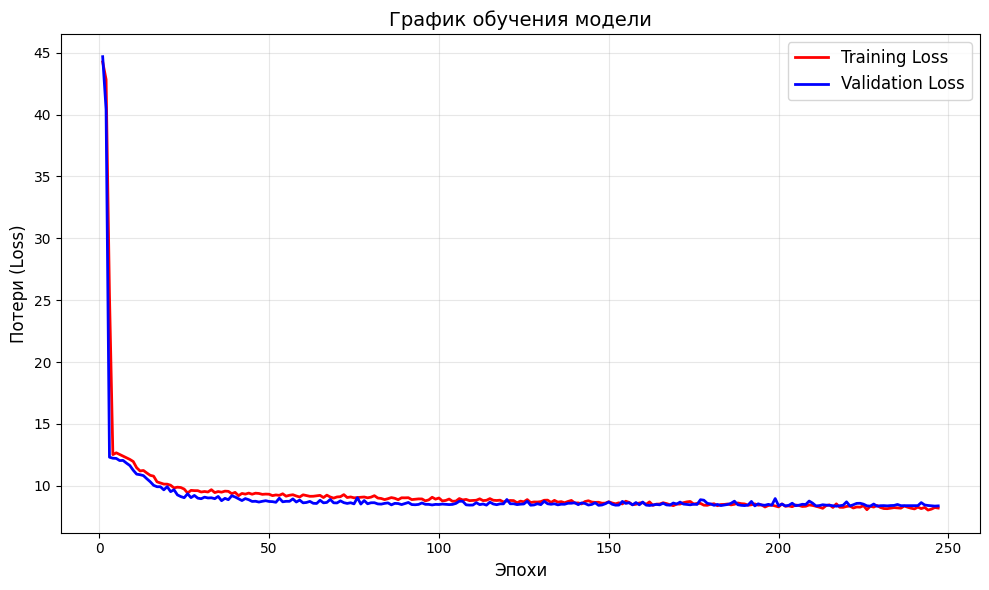


=== Сводка обучения ===
Лучшая эпоха: 217
Ошибка на обучении в лучшую эпоху: 8.5348
Лучшая ошибка на валидации: 8.3437
График сохранен как 'training_validation_loss.png'


In [ ]:
best_val_loss = float('inf') # Начальное значение лучшей ошибки на валидации (бесконечность).
patience_counter = 0 # Счетчик для ранней остановки.

# Инициализация списков для отслеживания истории потерь (график)
train_loss_history = []  # Будет хранить значения ошибок на обучении для каждой эпохи
val_loss_history = []    # Будет хранить значения ошибок на валидации для каждой эпохи
epoch_numbers = []       # Будет хранить номера эпох для оси X графика

print(f"Начало обучения на {NUM_EPOCHS} эпох...")
for epoch in range(NUM_EPOCHS):
    # --- Фаза обучения (Training) --- 
    model.train() # Переводим модель в режим обучения.
    train_loss = 0
    # tqdm - обертка для `train_loader` для отображения красивого progress bar'а.
    for x_batch, y_batch in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{NUM_EPOCHS} [Обучение]"):
        optimizer.zero_grad() # Обнуляем градиенты с предыдущего шага.
        y_pred = model(x_batch).squeeze() # Делаем предсказание и убираем лишние размерности.
        loss = criterion(y_pred, y_batch) # Считаем ошибку.
        loss.backward() # Вычисляем градиенты (обратное распространение ошибки).
        optimizer.step() # Обновляем веса модели.
        train_loss += loss.item() # Суммируем ошибку.
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Сохраняем значение ошибки на обучении для текущей эпохи (график)
    train_loss_history.append(avg_train_loss)

    # --- Фаза валидации (Validation) --- 
    model.eval() # Переводим модель в режим оценки (отключаются Dropout и т.д.).
    val_preds = []
    val_targets = []
    with torch.no_grad(): # В этом блоке градиенты не вычисляются для экономии ресурсов.
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch).squeeze()
            val_preds.append(y_pred.cpu().numpy()) # Собираем предсказания
            val_targets.append(y_batch.cpu().numpy()) # и реальные значения.
            
    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)
    # Считаем среднюю абсолютную ошибку (MAE) на валидационной выборке.
    avg_val_loss = mean_absolute_error(val_targets, val_preds)
    
    #  Сохраняем значение ошибки на валидации и номер эпохи (график)
    val_loss_history.append(avg_val_loss)
    epoch_numbers.append(epoch + 1)  # Нумерация эпох с 1, а не с 0
    
    print(f"Эпоха [{epoch+1}/{NUM_EPOCHS}] | Ошибка на обучении: {avg_train_loss:.4f} | Ошибка на валидации (MAE): {avg_val_loss:.4f}")

    # --- Ранняя остановка и сохранение лучшей модели ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Сохраняем состояние модели (ее веса), если она показала лучший результат.
        torch.save(model.state_dict(), 'best_multi_input_model.pth')
        print(f"Ошибка на валидации улучшилась. Модель сохранена в 'best_multi_input_model.pth'")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Ранняя остановка: ошибка не улучшалась {patience_counter} эпох.")
            break

#  Отрисовка графика потерь после завершения обучения 
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, train_loss_history, 'r-', linewidth=2, label='Training Loss')
plt.plot(epoch_numbers, val_loss_history, 'b-', linewidth=2, label='Validation Loss')

plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Потери (Loss)', fontsize=12)
plt.title('График обучения модели', fontsize=14)
plt.grid(True, alpha=0.3)  # Добавляем сетку с прозрачностью
plt.legend(fontsize=12)    
plt.tight_layout()         # Автоматически настраиваем отступы

plt.savefig('training_validation_loss.png', dpi=150)

# Показываем график
plt.show()

# Выводим сводную информацию о лучшей эпохе
if val_loss_history:  # Проверяем, что список не пустой
    best_val_loss_value = min(val_loss_history)  # Находим минимальное значение ошибки валидации
    best_epoch_idx = val_loss_history.index(best_val_loss_value)  # Находим индекс лучшей эпохи
    best_epoch_number = epoch_numbers[best_epoch_idx]  # Получаем номер лучшей эпохи
    
    print(f"\n=== Сводка обучения ===")
    print(f"Лучшая эпоха: {best_epoch_number}")
    print(f"Ошибка на обучении в лучшую эпоху: {train_loss_history[best_epoch_idx]:.4f}")
    print(f"Лучшая ошибка на валидации: {best_val_loss_value:.4f}")
    print(f"График сохранен как 'training_validation_loss.png'")

### Шаг 6: Финальная оценка на тестовой выборке



In [126]:
print("\n--- Тестирование ---")
# Загружаем веса лучшей модели, сохраненной ранее.
model.load_state_dict(torch.load('best_multi_input_model.pth'))
model.eval() # Переводим в режим оценки.

test_preds = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="[Тест]"):
        y_pred = model(x_batch).squeeze()
        test_preds.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

# Считаем и выводим финальные метрики на данных, которые модель еще не видела.
test_mse = mean_squared_error(test_targets, test_preds)
test_mae = mean_absolute_error(test_targets, test_preds)

print("\nИтоговые результаты на тестовой выборке:")
print(f"  Средняя квадратичная ошибка (MSE): {test_mse:.4f}")
print(f"  Средняя абсолютная ошибка (MAE): {test_mae:.4f}")


--- Тестирование ---


[Тест]:   0%|          | 0/32 [00:00<?, ?it/s]

[Тест]: 100%|██████████| 32/32 [00:00<00:00, 157.80it/s]


Итоговые результаты на тестовой выборке:
  Средняя квадратичная ошибка (MSE): 124.2903
  Средняя абсолютная ошибка (MAE): 8.5526
